In [1]:
import os
import kagglehub

# Point KaggleHub to the current folder where kaggle.json is located
os.environ["KAGGLE_CONFIG_DIR"] = os.getcwd()

# Download the dataset
path = kagglehub.dataset_download("evilspirit05/ecg-analysis")

print("Dataset downloaded successfully!")
print("Path to dataset files:", path)

/home/oconnecs/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset downloaded successfully!
Path to dataset files: /home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2


In [2]:
# List the contents of the dataset root folder
for root, dirs, files in os.walk(path):
    print(f"Folder: {root}")
    print(f"  Subfolders: {dirs[:5]}")
    print(f"  Files: {files[:5]}")
    break  # remove 'break' if you want to see full structure

Folder: /home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2
  Subfolders: ['ECG_DATA']
  Files: []


In [3]:
import os
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

# --------------------------------------------
# 1. Paths & Setup
# --------------------------------------------
dataset_path = path  # from kagglehub.dataset_download()
print("Dataset path:", dataset_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Dataset path: /home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2
Using device: cuda


In [4]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class ECGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform

        class_map = {
            "History of MI": 0,
            "abnormal heartbeat": 1,
            "Myocardial Infarction": 2,
            "Normal Person": 3
        }

        for class_name, label in class_map.items():
            for subdir, _, files in os.walk(root_dir):
                if class_name in subdir:
                    for file in files:
                        if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                            self.image_paths.append(os.path.join(subdir, file))
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        return image, label

# Example usage:
train_dir = "/home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2/ECG_DATA/train"
test_dir = "/home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2/ECG_DATA/test"

transform = transforms.Compose([
    transforms.Resize((228, 228)),
    transforms.ToTensor()
])

train_dataset = ECGDataset(train_dir, transform=transform)
test_dataset = ECGDataset(test_dir, transform=transform)

print("Train images:", len(train_dataset))
print("Test images:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

Train images: 3023
Test images: 928


Batch shape: torch.Size([32, 3, 228, 228])
Labels: ['Myocardial Infarction', 'Myocardial Infarction', 'Normal Person', 'Abnormal Heartbeat', 'Myocardial Infarction', 'Normal Person', 'Myocardial Infarction', 'History of MI']


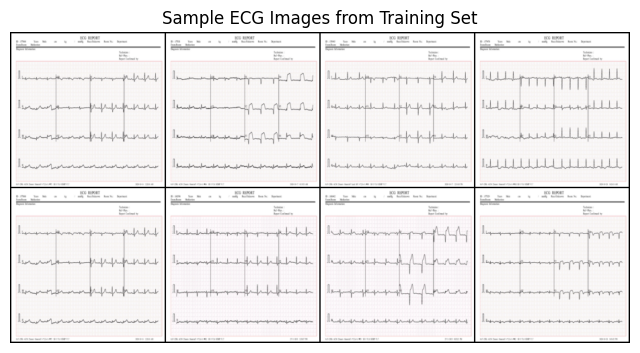

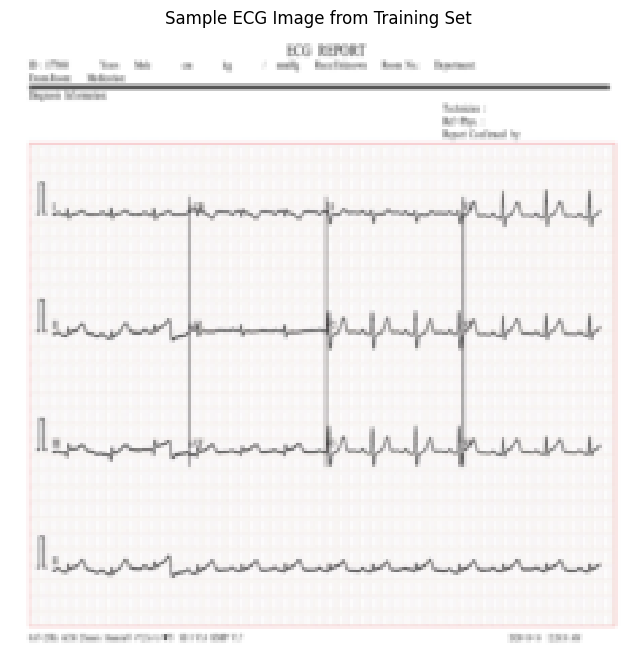

In [5]:

# --- Block 1: Define Classes ---
import matplotlib.pyplot as plt
import torchvision

# Class mapping (must match the dataset)
class_names = ["History of MI", "Abnormal Heartbeat", "Myocardial Infarction", "Normal Person"]

# Quick check of one batch
images, labels = next(iter(train_loader))

print("Batch shape:", images.shape)
print("Labels:", [class_names[l] for l in labels[:8]])

# Show sample grid
grid_img = torchvision.utils.make_grid(images[:8], nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0))
plt.title("Sample ECG Images from Training Set")
plt.axis("off")
plt.show()

# Show single image
grid_img = torchvision.utils.make_grid(images[0], nrow=4)
plt.figure(figsize=(8, 8))
plt.imshow(grid_img.permute(1, 2, 0), interpolation= 'nearest')
plt.title("Sample ECG Image from Training Set")
plt.axis("off")
plt.show()

In [6]:
# --- Block 2: Define Transformations ---

import torchvision.transforms as transforms

# Define the same normalization stats used during VGG16 training (on ImageNet)
# UPDATE: Using transforms to make images more realistic to reduce overfitting
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.RandomRotation(10),         # Random 10° rotation
    transforms.RandomHorizontalFlip(p=0.5),# Flip ECGs horizontally
    transforms.RandomAffine(0, translate=(0.05, 0.05)),  # Slight shift
    transforms.ColorJitter(brightness=0.2, contrast=0.2),# Simulate varied lighting
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])          # Simpler normalization
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [7]:
# --- Block 3: Create Dataset and DataLoaders ---

from torchvision import datasets
from torch.utils.data import DataLoader

# Point to your dataset folders
train_dir = os.path.join(path, "ECG_DATA/train")
test_dir = os.path.join(path, "ECG_DATA/test")

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Wrap in DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Confirm everything loaded correctly
print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Train size: 3023
Test size: 928
Classes: ['ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


In [8]:
# --- Block 4: Modify VGG16 for ECG classification ---

import torch
import torch.nn as nn
from torchvision.models import vgg16, VGG16_Weights

# Load pretrained VGG16
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)

# Optional: Freeze convolutional layers to keep pretrained features
for param in model.features.parameters():
    param.requires_grad = False

# Replace the classifier head (fully connected layers)
# Original VGG16 classifier has 4096 -> 4096 -> 1000
model.classifier = nn.Sequential(
    nn.Linear(25088, 1024),  # 512*7*7 input features → 1024 hidden units
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4),       # Output 4 ECG classes
    # nn.LogSoftmax(dim=1)
)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("Model ready on device:", device)

Model ready on device: cuda


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
patience = 3  # early stopping patience

# Loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.classifier.parameters(),
    lr=learning_rate,
    weight_decay=1e-5  # weight decay added to reduce overfitting
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
# ↓ Every 3 epochs, the LR is halved

# Early stopping variables
best_val_loss = float('inf')
counter = 0

# Training loop
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")

    # ----- TRAIN -----
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ----- VALIDATION -----
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)
    accuracy = 100 * correct / total

    print(f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | Val Accuracy: {accuracy:.2f}%")

    # ----- EARLY STOPPING -----
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")  # save best model
    else:
        counter += 1
        if counter >= patience:
            print("⏹ Early stopping triggered.")
            break

    # ----- LEARNING RATE SCHEDULER -----
    scheduler.step()

print("\n Training complete.")
print(f"Best Validation Loss: {best_val_loss:.4f}")


Epoch [1/10]


Train Loss: 1.2066 | Val Loss: 1.0380 | Val Accuracy: 52.16%

Epoch [2/10]


Train Loss: 0.9954 | Val Loss: 0.8001 | Val Accuracy: 70.47%

Epoch [3/10]


Train Loss: 0.8568 | Val Loss: 0.9428 | Val Accuracy: 66.38%

Epoch [4/10]


Train Loss: 0.7529 | Val Loss: 0.6446 | Val Accuracy: 74.89%

Epoch [5/10]


Train Loss: 0.6941 | Val Loss: 0.7095 | Val Accuracy: 72.63%

Epoch [6/10]


Train Loss: 0.6578 | Val Loss: 0.5505 | Val Accuracy: 78.88%

Epoch [7/10]


Train Loss: 0.6063 | Val Loss: 0.4958 | Val Accuracy: 82.11%

Epoch [8/10]


Train Loss: 0.5744 | Val Loss: 0.5532 | Val Accuracy: 79.53%

Epoch [9/10]


Train Loss: 0.5593 | Val Loss: 0.5452 | Val Accuracy: 78.02%

Epoch [10/10]


Train Loss: 0.5424 | Val Loss: 0.4528 | Val Accuracy: 83.73%

 Training complete.
Best Validation Loss: 0.4528


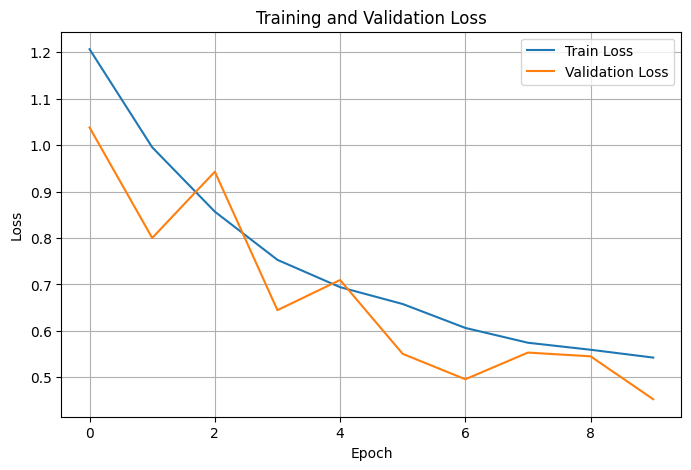

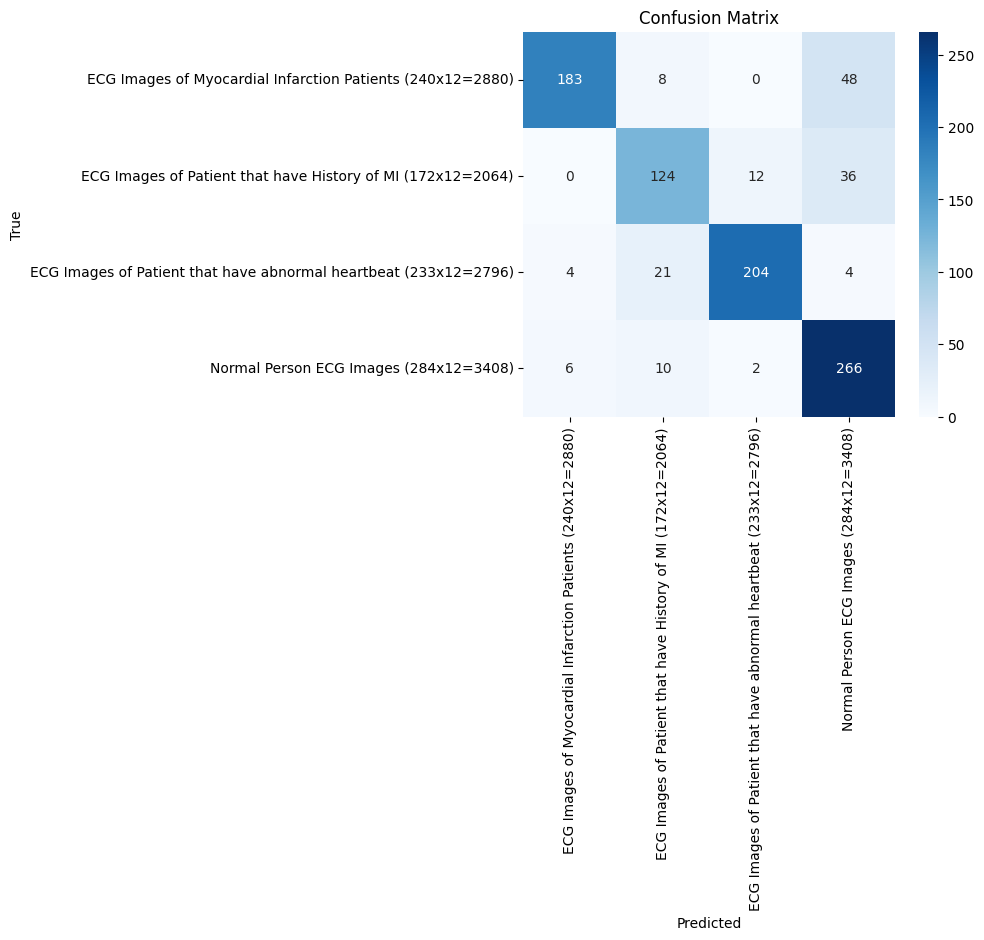


Classification Report:
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       0.95      0.77      0.85       239
     ECG Images of Patient that have History of MI (172x12=2064)       0.76      0.72      0.74       172
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.94      0.88      0.90       233
                          Normal Person ECG Images (284x12=3408)       0.75      0.94      0.83       284

                                                        accuracy                           0.84       928
                                                       macro avg       0.85      0.82      0.83       928
                                                    weighted avg       0.85      0.84      0.84       928



In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# ----- Plot loss curves -----
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# ----- Confusion Matrix -----
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
class_names = train_dataset.classes  # or manually define your ECG classes

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ----- Classification Report -----
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

✅ Final Test Accuracy: 79.09%

Classification Report:
                                                                  precision    recall  f1-score   support

      ECG Images of Myocardial Infarction Patients (240x12=2880)       0.81      0.93      0.87       239
     ECG Images of Patient that have History of MI (172x12=2064)       0.60      0.91      0.73       172
ECG Images of Patient that have abnormal heartbeat (233x12=2796)       0.97      0.48      0.65       233
                          Normal Person ECG Images (284x12=3408)       0.87      0.85      0.86       284

                                                        accuracy                           0.79       928
                                                       macro avg       0.81      0.79      0.78       928
                                                    weighted avg       0.83      0.79      0.78       928



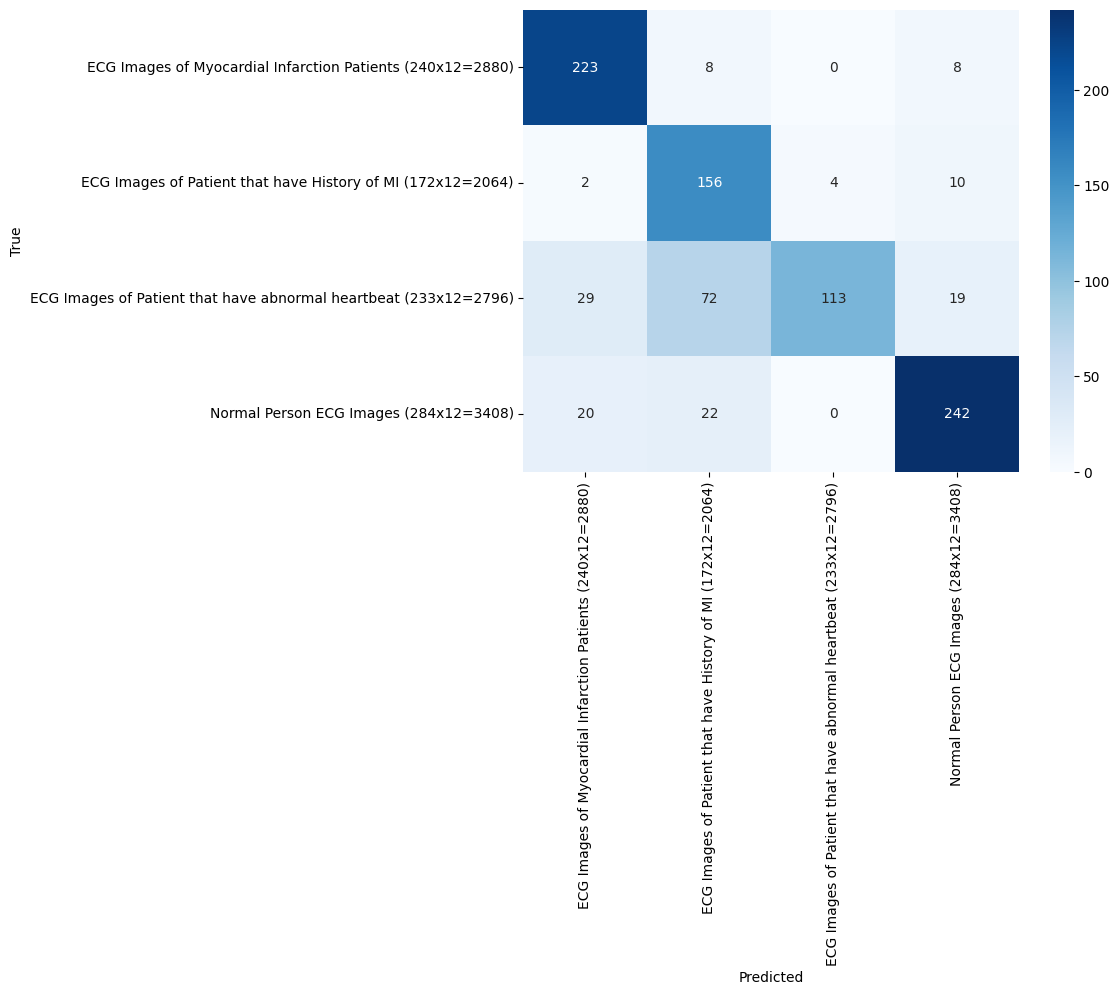

In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

dataset_dir = "/home/oconnecs/.cache/kagglehub/datasets/evilspirit05/ecg-analysis/versions/2/ECG_DATA"

# Use same transforms as before
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Reload the test dataset from the folder
test_dir = os.path.join(dataset_dir, "test")
test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Set model to evaluation mode
model.eval()

all_preds = []
all_labels = []

# Disable gradient calculation for speed
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = (all_preds == all_labels).mean() * 100
print(f"✅ Final Test Accuracy: {accuracy:.2f}%")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
# plt.title("Final Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()